In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, auc
import xgboost as xgb

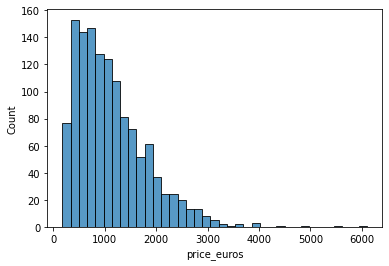

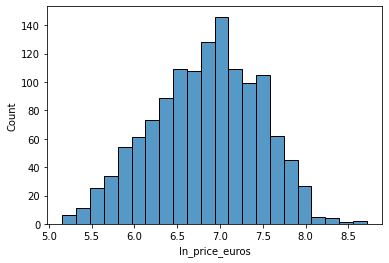

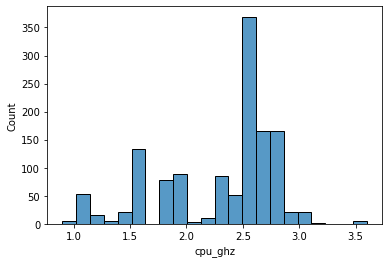

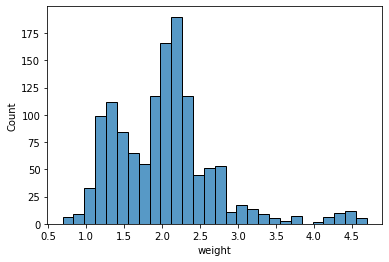

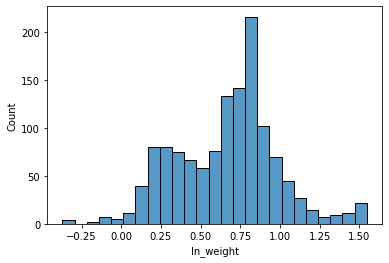

,company,typename,inches,ram,gpu,opsys,weight,price_euros,memory1,memory1_type,memory2,memory2_type,cpu_type,cpu_ghz,screentype,screensize,touchscreen,ln_price_euros,ln_weight
0,Apple,Ultrabook,13.3,8GB,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,128GB,SSD,N/A,N/A,Intel Core i5,2.3,IPS Panel Retina Display,2560x1600,0,7.200194,0.314811
1,Apple,Ultrabook,13.3,8GB,Intel HD Graphics 6000,macOS,1.34,898.94,128GB,Flash,N/A,N/A,Intel Core i5,1.8,N/A,1440x900,0,6.801216,0.292670
2,HP,Notebook,15.6,8GB,Intel HD Graphics 620,No OS,1.86,575.00,256GB,SSD,N/A,N/A,Intel Core i5 7200U,2.5,Full HD,1920x1080,0,6.354370,0.620576
3,Apple,Ultrabook,15.4,16GB,AMD Radeon Pro 455,macOS,1.83,2537.45,512GB,SSD,N/A,N/A,Intel Core i7,2.7,IPS Panel Retina Display,2880x1800,0,7.838915,0.604316
4,Apple,Ultrabook,13.3,8GB,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,256GB,SSD,N/A,N/A,Intel Core i5,3.1,IPS Panel Retina Display,2560x1600,0,7.497540,0.314811


In [2]:
#################################
# Data preperation and cleaning #
#################################

# Read in source data and clean: https://www.kaggle.com/muhammetvarl/laptop-price
df = pd.read_csv('laptop_data_prices.zip', encoding='latin1')

df.columns = df.columns.str.lower().str.replace(' ', '_')

# Exploratory Data Analysis: Determine which available features to drop
df = df.drop(['laptop_id', 'product'], axis=1)

# Feature Engineering: Split `memory` into multiple features
memories = df['memory'].str.split('+', expand=True).rename(columns={0: 'memory1', 1: 'memory2'})
for column in memories.columns:
    memory = memories[column].str.strip().str.split(' ', expand=True)
    df[column] = memory[0].replace({'1.0TB': '1TB'}).fillna("N/A")
    df[f'{column}_type'] = memory[1].fillna("N/A")
df = df.drop(['memory'], axis=1)

# Feature Engineering: Split cpu into chipname and speed
df['cpu_type'] = df['cpu'].str.extract(r'(?P<cpu>.*\s*) [0-9\.]*GHz')
df['cpu_ghz'] = df['cpu'].str.extract(r' (?P<ghz>[0-9\.]*)GHz').astype(float)
df = df.drop('cpu', axis=1)

# Feature Engineering: Split screentype into screen type, size, and touchscreen
df['screentype'] = df['screenresolution'].str.extract(r'(.*) [0-9]*x[0-9]*').fillna('N/A')
df['screentype'] = (
    df['screentype']
    .str.replace("IPS Panel Touchscreen / ", "")
    .str.replace(" / Touchscreen", "")
    .str.replace("Touchscreen / ", "")
)
df['screensize'] = df['screenresolution'].str.extract(r'([0-9]*x[0-9]*)')
df['touchscreen'] = df['screentype'].str.contains('Touchscreen').astype(int)
df = df.drop(['screenresolution'], axis=1)

# Convert weight to numerical feature
df['weight'] = df['weight'].str.slice(0, -2).astype(float)

# Exploratory Data Analysis: Determine transforms for continuous data
sns.histplot(df['price_euros'])
plt.show()
df['ln_price_euros'] = np.log(df['price_euros'])
sns.histplot(df['ln_price_euros'])
plt.show()
sns.histplot(df['cpu_ghz'])
plt.show()
sns.histplot(df['weight'])
plt.show()
df['ln_weight'] = np.log(df['weight'])
sns.histplot(df['ln_weight'])
plt.show()

# Clean up
display(df.head())

In [8]:
################
# Prepare data #
################

# Set target and features
target = 'ln_price_euros'
features = [
    'company',
    'typename', 
    'inches', 
    'ram', 
    'cpu_type',
    'cpu_ghz',
    'gpu',
    'opsys', 
    'ln_weight',
    'memory1',
    'memory1_type',
    'memory2',
    'memory2_type',
    'screentype',
    'screensize',
    'touchscreen'
]
df = df.copy()[[target] + features]

# Split data
df_full_train, df_test = train_test_split(
    df,
    test_size=0.20,
    random_state=1,
)
df_train, df_val = train_test_split(
    df_full_train,
    test_size=0.25,
    random_state=1,
)
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Extract target and encode
y_full_train = df_full_train.pop(target).values
y_train = df_train.pop(target).values
y_val = df_val.pop(target).values
y_test = df_test.pop(target).values

# Convert DataFrames to feature matrices
dv = DictVectorizer(sparse=False)
dv.fit(df.to_dict(orient='records'))
X_full_train = dv.transform(df_full_train.to_dict(orient='records'))
X_train = dv.transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))
X_test = dv.transform(df_test.to_dict(orient='records'))

In [9]:
# Feature Importance Analysis
rf = RandomForestRegressor(
  n_estimators=10,
  max_depth=20,
  random_state=1,
  n_jobs=-1,
)
rf.fit(X_train, y_train)

feature_rank = (
  pd
  .DataFrame(
    data=zip(dv.get_feature_names_out(), rf.feature_importances_),
    columns=['feature', 'importance'],
  )
  .sort_values('importance', ascending=False)
  .reset_index(drop=True)
)
feature_rank.head(20)

# Reduce features based on Feature Analysis above
features = [
    'typename',
    'memory1_type',
    'ln_weight',
    'ram',
    'memory1',
    'inches',
    'cpu_ghz',
    'gpu',
    'company',
    'cpu_type',
    'screensize',
    'screentype',
]

# Set (new) features
df = df.copy()[[target] + features]

# Split data (again)
df_full_train, df_test = train_test_split(
    df,
    test_size=0.20,
    random_state=1,
)
df_train, df_val = train_test_split(
    df_full_train,
    test_size=0.25,
    random_state=1,
)
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Extract target and encode
y_full_train = df_full_train.pop(target).values
y_train = df_train.pop(target).values
y_val = df_val.pop(target).values
y_test = df_test.pop(target).values

# Convert DataFrames to feature matrices
dv = DictVectorizer(sparse=False)
dv.fit(df.to_dict(orient='records'))
X_full_train = dv.transform(df_full_train.to_dict(orient='records'))
X_train = dv.transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))
X_test = dv.transform(df_test.to_dict(orient='records'))

In [11]:
display(set(df['typename']))
display(set(df['memory1_type']))
display(set(df['ram']))
display(set(df['memory1']))
display(set(df['gpu']))
display(set(df['company']))
display(set(df['cpu_type']))
display(set(df['screensize']))
display(set(df['screentype']))

{'2 in 1 Convertible',
 'Gaming',
 'Netbook',
 'Notebook',
 'Ultrabook',
 'Workstation'}

{'Flash', 'HDD', 'Hybrid', 'SSD'}

{'12GB', '16GB', '24GB', '2GB', '32GB', '4GB', '64GB', '6GB', '8GB'}

{'128GB',
 '16GB',
 '180GB',
 '1TB',
 '240GB',
 '256GB',
 '2TB',
 '32GB',
 '500GB',
 '508GB',
 '512GB',
 '64GB',
 '8GB'}

{'AMD FirePro W4190M',
 'AMD FirePro W4190M ',
 'AMD FirePro W5130M',
 'AMD FirePro W6150M',
 'AMD R17M-M1-70',
 'AMD R4 Graphics',
 'AMD Radeon 520',
 'AMD Radeon 530',
 'AMD Radeon 540',
 'AMD Radeon Pro 455',
 'AMD Radeon Pro 555',
 'AMD Radeon Pro 560',
 'AMD Radeon R2',
 'AMD Radeon R2 Graphics',
 'AMD Radeon R3',
 'AMD Radeon R4',
 'AMD Radeon R4 Graphics',
 'AMD Radeon R5',
 'AMD Radeon R5 430',
 'AMD Radeon R5 520',
 'AMD Radeon R5 M315',
 'AMD Radeon R5 M330',
 'AMD Radeon R5 M420',
 'AMD Radeon R5 M420X',
 'AMD Radeon R5 M430',
 'AMD Radeon R7',
 'AMD Radeon R7 Graphics',
 'AMD Radeon R7 M360',
 'AMD Radeon R7 M365X',
 'AMD Radeon R7 M440',
 'AMD Radeon R7 M445',
 'AMD Radeon R7 M460',
 'AMD Radeon R7 M465',
 'AMD Radeon R9 M385',
 'AMD Radeon RX 540',
 'AMD Radeon RX 550',
 'AMD Radeon RX 560',
 'AMD Radeon RX 580',
 'ARM Mali T860 MP4',
 'Intel Graphics 620',
 'Intel HD Graphics',
 'Intel HD Graphics 400',
 'Intel HD Graphics 405',
 'Intel HD Graphics 500',
 'Intel HD Graph

{'Acer',
 'Apple',
 'Asus',
 'Chuwi',
 'Dell',
 'Fujitsu',
 'Google',
 'HP',
 'Huawei',
 'LG',
 'Lenovo',
 'MSI',
 'Mediacom',
 'Microsoft',
 'Razer',
 'Samsung',
 'Toshiba',
 'Vero',
 'Xiaomi'}

{'AMD A10-Series 9600P',
 'AMD A10-Series 9620P',
 'AMD A10-Series A10-9620P',
 'AMD A12-Series 9700P',
 'AMD A12-Series 9720P',
 'AMD A4-Series 7210',
 'AMD A6-Series 7310',
 'AMD A6-Series 9220',
 'AMD A6-Series A6-9220',
 'AMD A8-Series 7410',
 'AMD A9-Series 9410',
 'AMD A9-Series 9420',
 'AMD A9-Series A9-9420',
 'AMD E-Series 6110',
 'AMD E-Series 7110',
 'AMD E-Series 9000',
 'AMD E-Series 9000e',
 'AMD E-Series E2-6110',
 'AMD E-Series E2-9000',
 'AMD E-Series E2-9000e',
 'AMD FX 8800P',
 'AMD FX 9830P',
 'AMD Ryzen 1600',
 'AMD Ryzen 1700',
 'Intel Atom X5-Z8350',
 'Intel Atom Z8350',
 'Intel Atom x5-Z8300',
 'Intel Atom x5-Z8350',
 'Intel Atom x5-Z8550',
 'Intel Celeron Dual Core 3205U',
 'Intel Celeron Dual Core 3855U',
 'Intel Celeron Dual Core N3050',
 'Intel Celeron Dual Core N3060',
 'Intel Celeron Dual Core N3350',
 'Intel Celeron Quad Core N3160',
 'Intel Celeron Quad Core N3450',
 'Intel Celeron Quad Core N3710',
 'Intel Core M',
 'Intel Core M 6Y30',
 'Intel Core M 6

{'1366x768',
 '1440x900',
 '1600x900',
 '1920x1080',
 '1920x1200',
 '2160x1440',
 '2256x1504',
 '2304x1440',
 '2400x1600',
 '2560x1440',
 '2560x1600',
 '2736x1824',
 '2880x1800',
 '3200x1800',
 '3840x2160'}

{'4K Ultra HD',
 'Full HD',
 'IPS Panel',
 'IPS Panel 4K Ultra HD',
 'IPS Panel Full HD',
 'IPS Panel Quad HD+',
 'IPS Panel Retina Display',
 'IPS Panel Touchscreen',
 'N/A',
 'Quad HD+',
 'Touchscreen'}

In [6]:
# Model tuning
scores = []
for d in [10, 15, 20, 25]:
  for n in range(10, 201, 10):
    rf = RandomForestRegressor(
      n_estimators=n,
      max_depth=d,
      random_state=1,
      n_jobs=-1,
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = round(mean_squared_error(y_val, y_pred, squared=False), 3)
    scores.append((d, n, rmse))
scores = pd.DataFrame(scores, columns=['d', 'n', 'rmse']).sort_values('rmse')
display(scores)

# D = 20, n = 50 => RMSE = 0.225

,d,n,rmse
44,20,50,0.225
64,25,50,0.225
24,15,50,0.226
66,25,70,0.226
45,20,60,0.227
...,...,...,...
12,10,130,0.240
13,10,140,0.240
2,10,30,0.241
1,10,20,0.242
